In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import os
from sqlalchemy import create_engine, text
from dotenv import load_dotenv

# ---------------------------------------------------------
# 1. 환경변수 로드 (notebooks 폴더의 상위 폴더에 있는 .env 로드)
# ---------------------------------------------------------
load_dotenv(dotenv_path="../.env")

# 2. DB 연결
DB_CONFIG = {
    "host": os.getenv("DB_HOST"),
    "port": int(os.getenv("DB_PORT", 3306)),
    "user": os.getenv("DB_USER", "admin"),
    "password": os.getenv("DB_PASSWORD"),
    "db": os.getenv("DB_NAME", "projectl")
}

db_url = f"mysql+pymysql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['db']}"
engine = create_engine(db_url)
print("✅ DB 연결 성공!")

# ---------------------------------------------------------
# 3. 데이터 수집 함수 (스키마 컬럼명 수정 완료)
# ---------------------------------------------------------
def get_item_data(item_name):
    conn = engine.connect()
    try:
        # (1) 아이템 ID 찾기
        item_sql = text("SELECT id FROM market_items WHERE name = :name")
        item_id = conn.execute(item_sql, {"name": item_name}).scalar()
        
        if not item_id:
            print(f"❌ '{item_name}' 아이템을 찾을 수 없습니다.")
            return None, None

        print(f"🔍 '{item_name}' (ID: {item_id}) 데이터 수집 중...")

        # (2) 가격 로그 가져오기 (컬럼명: current_min_price, logged_at)
        price_sql = text("""
            SELECT logged_at, current_min_price
            FROM market_price_logs
            WHERE item_id = :item_id
            ORDER BY logged_at ASC
        """)
        df_prices = pd.read_sql(price_sql, conn, params={"item_id": item_id})
        
        # (3) GPT Score 가져오기 (컬럼명: notice_date, gpt_score)
        notice_sql = text("""
            SELECT r.notice_date, i.gpt_score
            FROM item_notice_impacts i
            JOIN raw_notices r ON i.notice_id = r.id
            WHERE i.item_id = :item_id
            ORDER BY r.notice_date ASC
        """)
        df_notices = pd.read_sql(notice_sql, conn, params={"item_id": item_id})
        
        print(f"   - 가격 로그: {len(df_prices)}개")
        print(f"   - 관련 공지: {len(df_notices)}개")
        
        return df_prices, df_notices

    finally:
        conn.close()

# ---------------------------------------------------------
# [테스트] 아이템 이름 입력
# ---------------------------------------------------------
TARGET_ITEM = "운명의 파괴석"  # 👈 분석하고 싶은 아이템 이름
df_raw, df_gpt = get_item_data(TARGET_ITEM)

display(df_raw.head())
display(df_gpt.head())

✅ DB 연결 성공!
🔍 '운명의 파괴석' (ID: 66102006) 데이터 수집 중...
   - 가격 로그: 6929개
   - 관련 공지: 8개


,logged_at,current_min_price
0,2025-12-18 11:00:10.958607,99
1,2025-12-18 11:10:47.801668,100
2,2025-12-18 11:21:26.091468,98
3,2025-12-18 11:32:02.106706,100
4,2025-12-18 11:42:37.977318,98


,notice_date,gpt_score
0,2025-12-17,0.0
1,2025-12-24,0.0
2,2025-12-31,0.0
3,2026-01-07,0.5
4,2026-01-14,0.0


In [3]:
import numpy as np
from datetime import timedelta

# =========================================================
# [업그레이드] 함수 1: 원본 청소 후 30분봉 만들기
# =========================================================
def preprocess_ohlc_and_fill(df_raw):
    print("🧹 [1단계] Raw 데이터 정제 및 30분봉 변환...")
    
    df = df_raw.copy()
    
    # 1. 인덱스 설정 (필수)
    if 'logged_at' in df.columns:
        df['logged_at'] = pd.to_datetime(df['logged_at'])
        df.set_index('logged_at', inplace=True)

    # -----------------------------------------------------
    # 🚨 [핵심 추가] 원본(10분 단위) 단계에서 이상치 1차 제거
    # -----------------------------------------------------
    # 10분 데이터이므로 하루(24시간)를 보려면 window가 약 144개 필요합니다.
    # (6개/시간 * 24시간 = 144)
    raw_window = 432
    raw_sigma = 7 # 원본은 변동성이 더 크니 2.0보다 살짝 여유 있게 2.5 추천
    
    # 원본 가격 컬럼: 'current_min_price'
    rolling_mean = df['current_min_price'].rolling(window=raw_window, center=True).mean()
    rolling_std = df['current_min_price'].rolling(window=raw_window, center=True).std()
    
    upper = rolling_mean + (raw_sigma * rolling_std)
    lower = rolling_mean - (raw_sigma * rolling_std)
    
    outliers = (df['current_min_price'] > upper) | (df['current_min_price'] < lower)
    cnt = outliers.sum()
    
    if cnt > 0:
        print(f"   ✨ 원본 데이터에서 {cnt}개의 이상치를 미리 제거했습니다!")
        df.loc[outliers, 'current_min_price'] = np.nan
        df['current_min_price'] = df['current_min_price'].interpolate(method='linear')
    # -----------------------------------------------------
    
    # 2. 30분 단위 Resampling (이제 깨끗한 재료로 요리합니다)
    df_resampled = df['current_min_price'].resample('30min').agg(['first', 'max', 'min', 'last', 'mean'])
    df_resampled.columns = ['Open', 'High', 'Low', 'Close', 'Price_Mean']
    
    # 3. 빈칸 채우기
    df_filled = df_resampled.ffill().bfill()
    
    print(f"   - 정제 완료: {len(df_filled)}개 구간 (30분봉)")
    return df_filled

# =========================================================
# [추가됨] 함수 1.5: 이상치 제거 (Rolling Z-Score)
# =========================================================
def clean_outliers_rolling(df, column='Close', window=48, sigma=3):
    print(f"🧼 [1.5단계] 이상치 제거 중... (Window={window}, Sigma={sigma})")
    df_clean = df.copy()
    
    # 이동 평균과 표준편차 계산
    rolling_mean = df_clean[column].rolling(window=window, center=True).mean()
    rolling_std = df_clean[column].rolling(window=window, center=True).std()
    
    # 이상치 판별 기준
    upper_bound = rolling_mean + (sigma * rolling_std)
    lower_bound = rolling_mean - (sigma * rolling_std)
    
    # 이상치 조건 확인 및 개수 카운트
    outlier_mask = (df_clean[column] > upper_bound) | (df_clean[column] < lower_bound)
    outlier_count = outlier_mask.sum()
    
    if outlier_count > 0:
        print(f"   🚨 {outlier_count}개의 튀는 가격 발견! 부드럽게 보정합니다.")
        # 이상치를 NaN으로 변경 후 보간(Interpolation)
        df_clean.loc[outlier_mask, column] = np.nan
        df_clean[column] = df_clean[column].interpolate(method='linear')
    else:
        print("   ✅ 데이터가 아주 깨끗합니다.")
        
    return df_clean

# =========================================================
# 함수 2: GPT 스코어 매핑 (날짜 계산 로직)
# =========================================================
def apply_gpt_scores(df_price, df_gpt):
    print("🤖 [2단계] GPT 공지사항 점수 매핑 중...")
    
    df = df_price.copy()
    df['GPT_Score'] = 0.0 # 기본값 0
    
    if df_gpt is None or df_gpt.empty:
        print("   - 공지사항 데이터가 없습니다. (점수 0으로 진행)")
        return df

    count = 0
    for idx, row in df_gpt.iterrows():
        notice_date = pd.to_datetime(row['notice_date'])
        score = row['gpt_score']
        
        # [규칙 적용] 공지일 10:00 ~ 7일 뒤 06:00
        start_time = notice_date.replace(hour=10, minute=0, second=0)
        end_time = (notice_date + timedelta(days=7)).replace(hour=6, minute=0, second=0)
        
        # 해당 기간 마스킹
        mask = (df.index >= start_time) & (df.index < end_time)
        
        if mask.any():
            df.loc[mask, 'GPT_Score'] = score
            count += 1
            
    print(f"   - 총 {count}건의 공지사항 점수 반영 완료")
    return df

# =========================================================
# [실행] 파이프라인 연결 (순서 중요!)
# =========================================================

# 1. 가격 데이터 1차 정제 (빈칸 채우기)
df_temp = preprocess_ohlc_and_fill(df_raw)

# 2. [추가] 이상치 제거 (여기서 튀는 값을 잡습니다!)
df_clean_price = clean_outliers_rolling(df_temp, column='Price_Mean', window=48, sigma=3)

# 3. GPT 점수 결합
df_final = apply_gpt_scores(df_clean_price, df_gpt)

# 4. 결과 확인
print("-" * 30)
print(f"🗓️ 데이터 기간: {df_final.index.min()} ~ {df_final.index.max()}")
print("-" * 30)
display(df_final.tail())

🧹 [1단계] Raw 데이터 정제 및 30분봉 변환...
   ✨ 원본 데이터에서 1개의 이상치를 미리 제거했습니다!
   - 정제 완료: 2404개 구간 (30분봉)
🧼 [1.5단계] 이상치 제거 중... (Window=48, Sigma=3)
   🚨 2개의 튀는 가격 발견! 부드럽게 보정합니다.
🤖 [2단계] GPT 공지사항 점수 매핑 중...
   - 총 8건의 공지사항 점수 반영 완료
------------------------------
🗓️ 데이터 기간: 2025-12-18 11:00:00 ~ 2026-02-06 12:30:00
------------------------------


,Open,High,Low,Close,Price_Mean,GPT_Score
logged_at,,,,,,
2026-02-06 10:30:00,335.0,335.0,314.0,314.0,323.333333,0.0
2026-02-06 11:00:00,318.0,334.0,315.0,334.0,322.333333,0.0
2026-02-06 11:30:00,331.0,337.0,331.0,333.0,333.666667,0.0
2026-02-06 12:00:00,318.0,340.0,318.0,340.0,327.333333,0.0
2026-02-06 12:30:00,342.0,342.0,342.0,342.0,342.000000,0.0


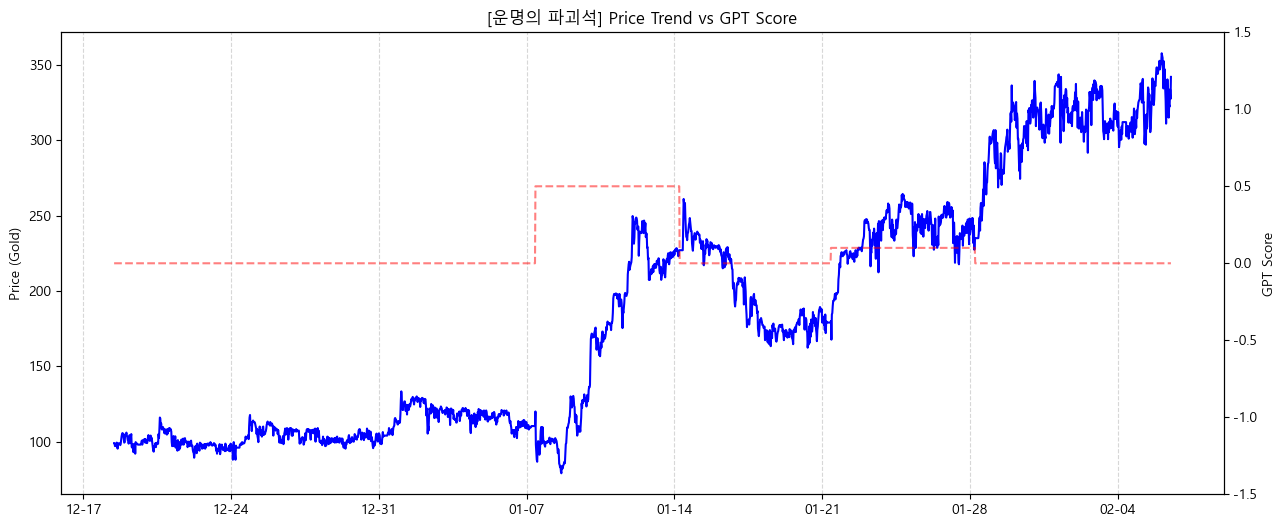

,Open,High,Low,Close,Price_Mean,GPT_Score
logged_at,,,,,,
2026-02-06 10:30:00,335.0,335.0,314.0,314.0,323.333333,0.0
2026-02-06 11:00:00,318.0,334.0,315.0,334.0,322.333333,0.0
2026-02-06 11:30:00,331.0,337.0,331.0,333.0,333.666667,0.0
2026-02-06 12:00:00,318.0,340.0,318.0,340.0,327.333333,0.0
2026-02-06 12:30:00,342.0,342.0,342.0,342.0,342.000000,0.0


In [4]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# ---------------------------------------------------------
# 3. 시각화 (확인용)
# ---------------------------------------------------------
plt.figure(figsize=(15, 6))

# 가격 그래프 (파란색)
ax1 = plt.gca()
ax1.plot(df_final.index, df_final['Price_Mean'], color='blue', label='Avg Price')
ax1.set_ylabel('Price (Gold)')

# GPT 점수 그래프 (빨간색, y축 공유)
ax2 = ax1.twinx()
ax2.plot(df_final.index, df_final['GPT_Score'], color='red', linestyle='--', alpha=0.5, label='GPT Score')
ax2.set_ylabel('GPT Score')
ax2.set_ylim(-1.5, 1.5)

# 2. 눈금 형식: '월-일' 형태로 보여줘라 (예: 01-29)
# 연도까지 보고 싶으면 '%Y-%m-%d'로 바꾸시면 됩니다.
ax1.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.WEDNESDAY, interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax1.grid(True, which='major', axis='x', linestyle='--', alpha=0.5) # 수요일마다 세로 점선 추가

plt.title(f"[{TARGET_ITEM}] Price Trend vs GPT Score")
plt.show()

# 데이터 확인
display(df_final.tail())

In [5]:
import numpy as np

# 1. 원본 복사
df_ml = df_final.copy()

# ---------------------------------------------------------
# 2. 기술적 지표 (이동평균, 변동성, RSI)
# ---------------------------------------------------------
# 가격의 흐름(Trend)을 모델에게 알려줍니다.
df_ml['MA_5'] = df_ml['Close'].rolling(window=5).mean()    # 2.5시간 평균
df_ml['MA_48'] = df_ml['Close'].rolling(window=48).mean()  # 24시간(1일) 평균
df_ml['Std_20'] = df_ml['Close'].rolling(window=20).std()  # 변동성

# RSI (상대강도지수)
delta = df_ml['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df_ml['RSI'] = 100 - (100 / (1 + rs))

# ---------------------------------------------------------
# 3. [핵심] Lag Features (시차 데이터)
# ---------------------------------------------------------
# 모델 학습용으로 "과거의 정답"을 미리 만들어두는 겁니다.
# (나중에 예측할 때는 이 컬럼을 우리가 직접 채워넣으며 예측해야 합니다)
df_ml['Close_Lag1'] = df_ml['Close'].shift(1)  # 30분 전
df_ml['Close_Lag2'] = df_ml['Close'].shift(2)  # 1시간 전
df_ml['GPT_Lag1'] = df_ml['GPT_Score'].shift(1) # 30분 전 공지 점수

# ---------------------------------------------------------
# 4. 시간 정보 (Time Features)
# ---------------------------------------------------------
# 미래의 시간(요일, 시간)은 우리가 달력만 보면 100% 알 수 있으므로 아주 좋은 힌트입니다.
df_ml['Hour'] = df_ml.index.hour
df_ml['DayOfWeek'] = df_ml.index.dayofweek # 0:월 ~ 6:일

# ---------------------------------------------------------
# 5. Target (정답지: 다음 30분 뒤의 가격)
# ---------------------------------------------------------
df_ml['Target'] = df_ml['Close'].shift(-1)

# 결측치 제거 (이동평균 등으로 생긴 앞부분 빈칸 삭제)
df_ml = df_ml.dropna()

print(f"📚 머신러닝 데이터 준비 완료: {df_ml.shape}")
display(df_ml.tail())

📚 머신러닝 데이터 준비 완료: (2356, 16)


,Open,High,Low,Close,Price_Mean,GPT_Score,MA_5,MA_48,Std_20,RSI,Close_Lag1,Close_Lag2,GPT_Lag1,Hour,DayOfWeek,Target
logged_at,,,,,,,,,,,,,,,,
2026-02-06 10:00:00,320.0,320.0,310.0,310.0,315.000000,0.0,328.8,336.208333,16.129411,39.622642,335.0,328.0,0.0,10,4,314.0
2026-02-06 10:30:00,335.0,335.0,314.0,314.0,323.333333,0.0,327.0,335.958333,16.781177,44.000000,310.0,335.0,0.0,10,4,334.0
2026-02-06 11:00:00,318.0,334.0,315.0,334.0,322.333333,0.0,324.2,335.812500,16.229522,49.090909,314.0,310.0,0.0,11,4,333.0
2026-02-06 11:30:00,331.0,337.0,331.0,333.0,333.666667,0.0,325.2,335.791667,15.658443,45.410628,334.0,314.0,0.0,11,4,340.0
2026-02-06 12:00:00,318.0,340.0,318.0,340.0,327.333333,0.0,326.2,336.270833,14.592356,52.879581,333.0,334.0,0.0,12,4,342.0


📚 XGB 학습 데이터: (2247, 9) ( ~ 2026-02-04 06:00:00)
📝 XGB 검증 데이터: (109, 9)
⚡ LightGBM 학습 시작...
🔮 LightGBM 미래 3일 예측 시작...


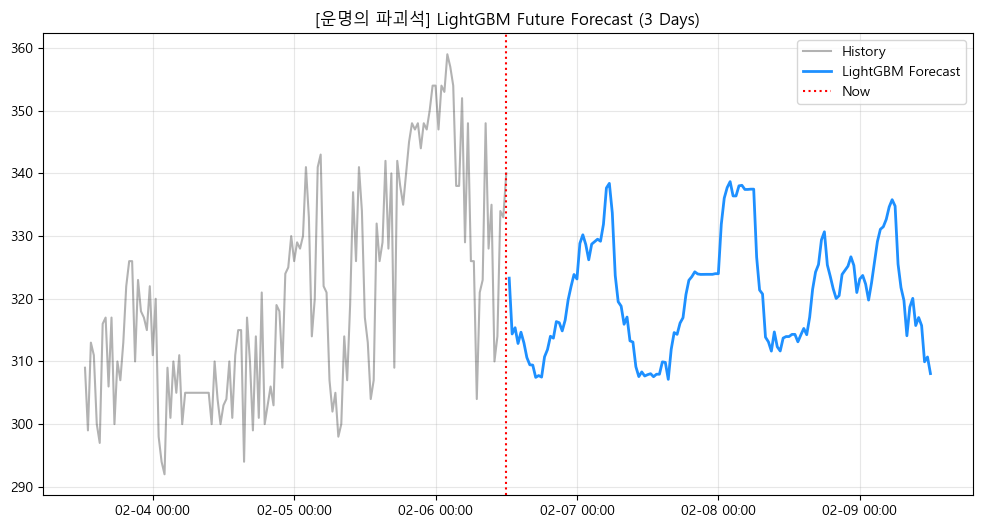

📊 LightGBM 3일 뒤 예상가: 308 G


In [6]:
# ---------------------------------------------------------
# 1. 학습 데이터 준비 (규칙: 2월 4일 06:00 이전만 사용)
# ---------------------------------------------------------
# df_ml은 이미 정제 및 피처 엔지니어링이 끝난 데이터라고 가정합니다.
train_cutoff = pd.to_datetime("2026-02-04 06:00:00")

features = [
    'MA_5', 'MA_48', 'Std_20', 'RSI',
    'Close_Lag1', 'Close_Lag2', 'GPT_Lag1',
    'Hour', 'DayOfWeek'
]
target = 'Target'

# 학습용 데이터 (Cutoff 이전)
X_train = df_ml[df_ml.index < train_cutoff][features]
y_train = df_ml[df_ml.index < train_cutoff][target]

# 검증용 데이터 (Cutoff 이후 ~ 현재) - 과적합 방지용
X_valid = df_ml[df_ml.index >= train_cutoff][features]
y_valid = df_ml[df_ml.index >= train_cutoff][target]

print(f"📚 XGB 학습 데이터: {X_train.shape} ( ~ {train_cutoff})")
print(f"📝 XGB 검증 데이터: {X_valid.shape}")

import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from lightgbm import LGBMRegressor

# ---------------------------------------------------------
# 1. 모델 정의 (LightGBM)
# ---------------------------------------------------------
print("⚡ LightGBM 학습 시작...")

model_lgbm = LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=5,
    random_state=42,
    n_jobs=-1,
    force_col_wise=True,
    verbose=-1
)

# ---------------------------------------------------------
# 2. 학습
# ---------------------------------------------------------
model_lgbm.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric='rmse',
    callbacks=[]
)

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import timedelta

# ---------------------------------------------------------
# 1. 재귀적 예측 함수 (LightGBM용)
# ---------------------------------------------------------
def recursive_forecast_lgbm(model, df_initial, features, steps=144):
    future_predictions = []
    future_dates = []
    
    # 히스토리 버퍼
    history_prices = df_initial['Close'].iloc[-100:].tolist()
    last_row = df_initial.iloc[[-1]].copy()
    current_time = last_row.index[0]
    
    for i in range(steps):
        # 예측
        pred_price = model.predict(last_row[features])[0]
        
        future_predictions.append(pred_price)
        next_time = current_time + timedelta(minutes=30)
        future_dates.append(next_time)
        
        # 업데이트 로직
        history_prices.append(pred_price)
        if len(history_prices) > 100: history_prices.pop(0)
        
        s_history = pd.Series(history_prices)
        last_row['MA_5'] = s_history.rolling(5).mean().iloc[-1]
        last_row['MA_48'] = s_history.rolling(48).mean().iloc[-1]
        last_row['Std_20'] = s_history.rolling(20).std().iloc[-1]
        
        delta = s_history.diff()
        gain = (delta.where(delta > 0, 0)).rolling(14).mean().iloc[-1]
        loss = (-delta.where(delta < 0, 0)).rolling(14).mean().iloc[-1]
        if loss == 0: last_row['RSI'] = 100
        else: last_row['RSI'] = 100 - (100 / (1 + (gain / loss)))
            
        last_row['Close_Lag2'] = last_row['Close_Lag1']
        last_row['Close_Lag1'] = pred_price
        last_row['GPT_Lag1'] = 0.0
        last_row['Hour'] = next_time.hour
        last_row['DayOfWeek'] = next_time.dayofweek
        current_time = next_time
        
    return pd.DataFrame({'Date': future_dates, 'Price': future_predictions})

# ---------------------------------------------------------
# 2. 실행 및 시각화
# ---------------------------------------------------------
print("🔮 LightGBM 미래 3일 예측 시작...")
df_future_lgbm = recursive_forecast_lgbm(model_lgbm, df_ml, features)

plt.figure(figsize=(12, 6))

# 과거 데이터
history_view = df_ml.tail(144) # 최근 3일치
plt.plot(history_view.index, history_view['Close'], label='History', color='black', alpha=0.3)

# LightGBM 예측
plt.plot(df_future_lgbm['Date'], df_future_lgbm['Price'],
         label='LightGBM Forecast', color='dodgerblue', linewidth=2)

plt.axvline(df_ml.index[-1], color='red', linestyle=':', label='Now')
plt.title(f"[{TARGET_ITEM}] LightGBM Future Forecast (3 Days)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.show()

print(f"📊 LightGBM 3일 뒤 예상가: {df_future_lgbm['Price'].iloc[-1]:.0f} G")

📚 XGB 학습 데이터: (2247, 9) ( ~ 2026-02-04 06:00:00)
📝 XGB 검증 데이터: (109, 9)

🔥 XGBoost 학습 시작...
✅ XGBoost 학습 완료!
🔮 지금(2026-02-06 12:00:00)부터 향후 3일간 예측 시작...
✅ XGB 미래 예측 완료!


,날짜,예측가격
0,2026-02-06 12:30:00,323.948029
1,2026-02-06 13:00:00,319.992371
2,2026-02-06 13:30:00,318.387238
3,2026-02-06 14:00:00,319.033142
4,2026-02-06 14:30:00,319.765869



📊 [XGBoost 3일 예측 리포트]
   - 예상 최저가: 316 G
   - 예상 최고가: 324 G
   - 3일 뒤 마감: 318 G


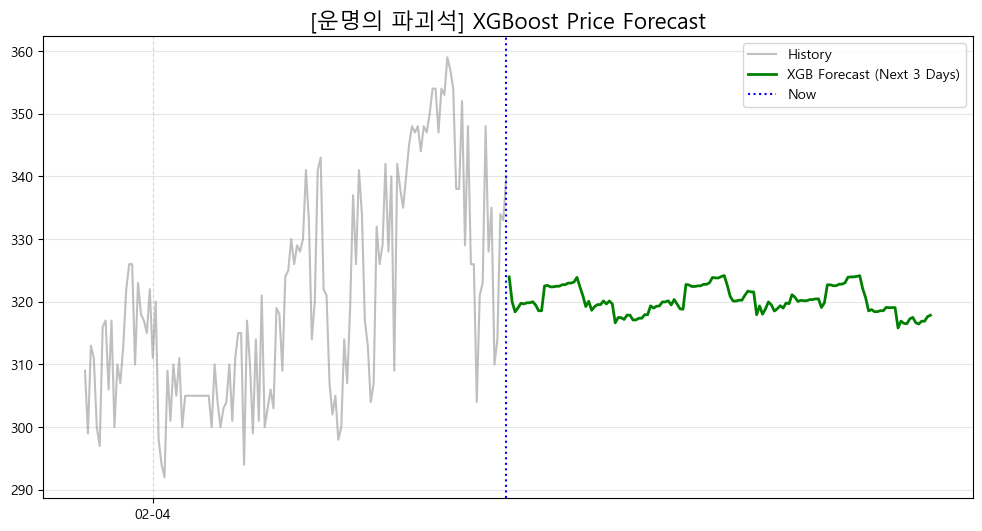

In [7]:
import xgboost as xgb
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import timedelta

# ---------------------------------------------------------
# 1. 학습 데이터 준비 (규칙: 2월 4일 06:00 이전만 사용)
# ---------------------------------------------------------
# df_ml은 이미 정제 및 피처 엔지니어링이 끝난 데이터라고 가정합니다.
train_cutoff = pd.to_datetime("2026-02-04 06:00:00")

features = [
    'MA_5', 'MA_48', 'Std_20', 'RSI',
    'Close_Lag1', 'Close_Lag2', 'GPT_Lag1',
    'Hour', 'DayOfWeek'
]
target = 'Target'

# 학습용 데이터 (Cutoff 이전)
X_train = df_ml[df_ml.index < train_cutoff][features]
y_train = df_ml[df_ml.index < train_cutoff][target]

# 검증용 데이터 (Cutoff 이후 ~ 현재) - 과적합 방지용
X_valid = df_ml[df_ml.index >= train_cutoff][features]
y_valid = df_ml[df_ml.index >= train_cutoff][target]

print(f"📚 XGB 학습 데이터: {X_train.shape} ( ~ {train_cutoff})")
print(f"📝 XGB 검증 데이터: {X_valid.shape}")

# ---------------------------------------------------------
# 2. XGBoost 모델 학습
# ---------------------------------------------------------
print("\n🔥 XGBoost 학습 시작...")
model_xgb = xgb.XGBRegressor(
    n_estimators=2000,       # 학습 횟수 (넉넉하게)
    learning_rate=0.01,      # 천천히 꼼꼼하게
    max_depth=6,             # 나무 깊이
    subsample=0.8,           # 데이터 샘플링
    colsample_bytree=0.8,    # 컬럼 샘플링
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50 # 50번 동안 성능 향상 없으면 멈춤
)

model_xgb.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    verbose=False  # 로그 너무 많이 뜨면 지저분해서 껐습니다
)
print("✅ XGBoost 학습 완료!")

# ---------------------------------------------------------
# 3. [핵심] 미래 3일 재귀적 예측 (Recursive Forecasting)
# ---------------------------------------------------------
# NeuralProphet은 알아서 해주지만, XGB는 우리가 직접 Loop를 돌려야 합니다.
print(f"🔮 지금({df_ml.index[-1]})부터 향후 3일간 예측 시작...")

future_predictions = []
future_dates = []

# 가장 마지막 데이터(현재 시점)를 가져와서 시작점으로 삼습니다.
last_row = df_ml.iloc[[-1]].copy()
current_time = last_row.index[0]

# 144스텝(3일) 반복
for i in range(144):
    # 1. 현재 상태로 다음 스텝 예측
    pred_price = model_xgb.predict(last_row[features])[0]
    
    # 2. 결과 저장
    next_time = current_time + timedelta(minutes=30)
    future_predictions.append(pred_price)
    future_dates.append(next_time)
    
    # 3. [중요] 다음 예측을 위해 '과거 정보(Lags)' 업데이트 (Shift)
    # 오늘 예측한 가격(pred_price)이 내일의 '어제 가격(Lag1)'이 됩니다.
    
    # Lag2 <- Lag1 (밀어내기)
    last_row['Close_Lag2'] = last_row['Close_Lag1']
    # Lag1 <- 방금 예측한 값 (채우기)
    last_row['Close_Lag1'] = pred_price
    
    # GPT Lag (미래 공지사항은 없으므로 0으로 가정, 만약 있으면 여기서 넣어줌)
    last_row['GPT_Lag1'] = 0.0
    
    # 시간 정보 업데이트
    last_row['Hour'] = next_time.hour
    last_row['DayOfWeek'] = next_time.dayofweek
    
    # (참고) MA, RSI 등은 재귀적으로 계산하기 복잡하므로 
    # 단기 예측에서는 직전 값을 유지하거나, Lag값만으로 추세를 잡게 둡니다.
    
    # 현재 시간 갱신
    current_time = next_time

# DataFrame으로 변환
forecast_3days_xgb = pd.DataFrame({
    '날짜': future_dates,
    '예측가격': future_predictions
})

print("✅ XGB 미래 예측 완료!")
display(forecast_3days_xgb.head())

# ---------------------------------------------------------
# 4. 결과 시각화
# ---------------------------------------------------------
plt.figure(figsize=(12, 6))

# (1) 과거 데이터 (최근 5일치)
recent_view = df_ml.tail(144)
plt.plot(recent_view.index, recent_view['Close'], label='History', color='gray', alpha=0.5)

# (2) XGB 예측선
plt.plot(forecast_3days_xgb['날짜'], forecast_3days_xgb['예측가격'],
         label='XGB Forecast (Next 3 Days)', color='green', linewidth=2)

# 기준선
current_now = df_ml.index[-1]
plt.axvline(current_now, color='blue', linestyle=':', label='Now')

plt.title(f"[{TARGET_ITEM}] XGBoost Price Forecast", fontsize=16)
plt.legend()
plt.grid(True, alpha=0.3)

# 날짜 포맷
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.WEDNESDAY, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax.grid(True, which='major', axis='x', linestyle='--', alpha=0.5) # 수요일마다 세로 점선 추가plt.show()

# ---------------------------------------------------------
# 5. 요약 리포트
# ---------------------------------------------------------
min_xgb = forecast_3days_xgb['예측가격'].min()
max_xgb = forecast_3days_xgb['예측가격'].max()
last_xgb = forecast_3days_xgb['예측가격'].iloc[-1]

print(f"\n📊 [XGBoost 3일 예측 리포트]")
print(f"   - 예상 최저가: {min_xgb:.0f} G")
print(f"   - 예상 최고가: {max_xgb:.0f} G")
print(f"   - 3일 뒤 마감: {last_xgb:.0f} G")

✅ NeuralProphet용 데이터 준비 완료


,ds,y,GPT_Score
2399,2026-02-06 10:30:00,314.0,0.0
2400,2026-02-06 11:00:00,334.0,0.0
2401,2026-02-06 11:30:00,333.0,0.0
2402,2026-02-06 12:00:00,340.0,0.0
2403,2026-02-06 12:30:00,342.0,0.0


INFO - (NP.config.__post_init__) - Trend reg lambda ignored due to no changepoints.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency 30min corresponds to 99.956% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 30min
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 90


🧠 [3일 단기 속성반] 모델 학습 시작... (목표: 144스텝)


Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

✅ 최적화된 모델 저장 완료: lostark_price_model.np
   이제 이 모델은 '3일 뒤'까지만 예측하지만, 그만큼 더 정교할 겁니다!
📂 [3일 예측 전용] 모델을 불러오는 중...


Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency 30min corresponds to 99.958% of the data.


✅ 모델 로딩 완료! (학습 과정 없이 바로 예측 가능)


INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 30min
WARNING - (NP.df_utils.check_dataframe) - Encountered future regressor with only unique values in training set across all IDs.Automatically removed variable.
WARNING - (NP.data.processing._check_dataframe) - Removing regressor GPT_Score because it is not present in the data.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency 30min corresponds to 99.74% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 30min
INFO - (NP.df_utils._infer_frequency) - Major frequency 30min corresponds to 99.74% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 30min
INFO - (NP.data.processing._handle_missing_data) - Dropped 144 rows at the end with NaNs in 'y' column.


🔮 지금(2026-02-06 12:38:21.860357)부터 향후 3일간 예측 데이터 추출 중...


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


✅ NaN 해결 완료! 이제 숫자가 꽉 차 있습니다.


,날짜,예측가격
0,2026-02-06 13:00:00,334.972412
1,2026-02-06 13:30:00,337.737915
2,2026-02-06 14:00:00,317.603210
3,2026-02-06 14:30:00,341.516693
4,2026-02-06 15:00:00,328.348328
5,2026-02-06 15:30:00,333.677612
6,2026-02-06 16:00:00,337.394470
7,2026-02-06 16:30:00,342.030243
8,2026-02-06 17:00:00,343.740387
9,2026-02-06 17:30:00,354.402466


,날짜,예측가격
139,2026-02-09 10:30:00,365.334412
140,2026-02-09 11:00:00,366.772980
141,2026-02-09 11:30:00,368.759827
142,2026-02-09 12:00:00,375.772766
143,2026-02-09 12:30:00,386.605377


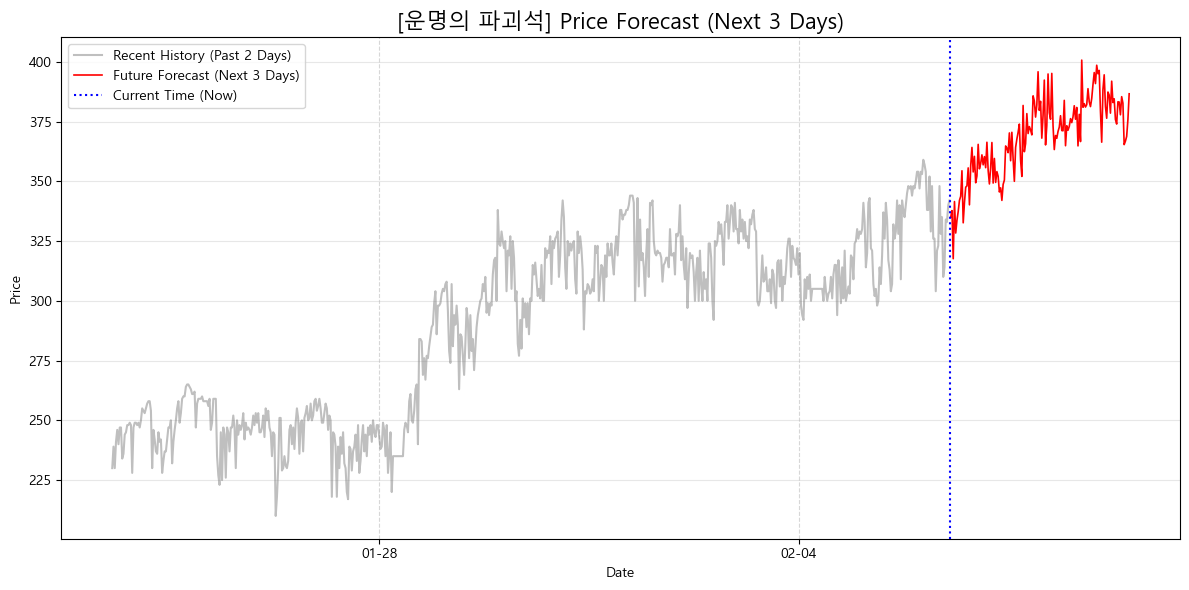


📊 [3일 단기 예측 리포트]
   - 예측 구간: 2026-02-06 13:00:00 ~ 2026-02-09 12:30:00
   - 예상 최저가: 318 G
   - 예상 최고가: 401 G
   - 3일 뒤 마감: 387 G


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from neuralprophet import load
import torch
import pandas as pd
from neuralprophet import NeuralProphet, save, set_random_seed

# ---------------------------------------------------------
# 1. 설정 및 데이터 준비
# ---------------------------------------------------------
set_random_seed(42)

# PyTorch 보안 해제 (학습 시엔 필요 없지만 습관적으로 넣어두면 안전)
_original_torch_load = torch.load
def patched_torch_load(*args, **kwargs):
    if 'weights_only' not in kwargs:
        kwargs['weights_only'] = False
    return _original_torch_load(*args, **kwargs)
torch.load = patched_torch_load

# 데이터 준비 (오전 6시 이전)
train_cutoff = pd.to_datetime("2026-02-04 06:00:00")
df_np = df_final.reset_index()[['logged_at', 'Close', 'GPT_Score']].copy()
df_np.columns = ['ds', 'y', 'GPT_Score']
df_train = df_np[df_np['ds'] < train_cutoff]

print("✅ NeuralProphet용 데이터 준비 완료")
display(df_np.tail())

# ---------------------------------------------------------
# 2. 모델 정의
# ---------------------------------------------------------
def NeuralProphet_fit(FORECAST_HORIZON):
    m = NeuralProphet(
        n_forecasts=FORECAST_HORIZON,
        n_lags=240,
        
        n_changepoints=20,     # 좀 더 세밀하게 꺾임을 감지하도록 늘림
        trend_reg=0.05,
        weekly_seasonality=True, # 수요일 점검 등의 주간 패턴 학습
        daily_seasonality=True,  # 새벽/저녁 패턴 학습
        yearly_seasonality=False,# 1년치 데이터는 아니므로 끔
        learning_rate=0.01,
        growth='off'
    )

    # 3. GPT 점수(공지사항)를 '미래를 아는 변수'로 추가
    # (우리가 미래 공지사항은 없다고(0) 가정하고 입력할 것이기 때문)
    m.add_future_regressor("GPT_Score")

    # ---------------------------------------------------------
    # 3. 재학습 및 저장
    # ---------------------------------------------------------
    print(f"🧠 [3일 단기 속성반] 모델 학습 시작... (목표: {FORECAST_HORIZON}스텝)")

    # 학습 (보안 옵션 적용)
    m.fit(df_train, freq="30min", num_workers=0, checkpointing=False)

    # 모델 덮어쓰기
    model_filename = "lostark_price_model.np"
    save(m, model_filename)

    print(f"✅ 최적화된 모델 저장 완료: {model_filename}")
    print("   이제 이 모델은 '3일 뒤'까지만 예측하지만, 그만큼 더 정교할 겁니다!")

FORECAST_HORIZON = 144
NeuralProphet_fit(FORECAST_HORIZON)

# ---------------------------------------------------------
# 2. 저장된 모델 불러오기 (Load)
# ---------------------------------------------------------
print("📂 [3일 예측 전용] 모델을 불러오는 중...")
# 아까 저장한 파일명 (lostark_price_model.np)
loaded_model = load("lostark_price_model.np")
print("✅ 모델 로딩 완료! (학습 과정 없이 바로 예측 가능)")

# ---------------------------------------------------------
# 3. '현재(Now)' 설정 및 최신 데이터 준비
# ---------------------------------------------------------
# [실전용] 서버에서는 아래 코드를 주석 해제해서 쓰세요!
current_now = pd.Timestamp.now()

# 전체 데이터 중 '현재 시간(Now) 이전'의 데이터만 잘라서 가져옵니다.
df_recent = df_np[df_np['ds'] <= current_now].copy()

# ---------------------------------------------------------
# 4. 미래 3일 예측 준비
# ---------------------------------------------------------
# 예측 기간: 3일 * 24시간 * 2 (30분 단위) = 144개
forecast_steps = 144

# 미래 GPT 점수(공지사항) 준비 (3일치 = 144개)
# (만약 내일 점검 공지가 있다면 여기에 점수를 넣어주면 됩니다)
future_regressors = pd.DataFrame(data={'GPT_Score': [0.0] * forecast_steps})

# [핵심] df_recent(과거~현재)를 넣어주면, 자동으로 '현재' 이후의 날짜를 만들어줍니다.
future = loaded_model.make_future_dataframe(
    df_recent,
    periods=forecast_steps,
    n_historic_predictions=False,
    regressors_df=future_regressors
)

# ---------------------------------------------------------
# 5. [진짜 최종] 대각선 추출법으로 NaN 완벽 해결
# ---------------------------------------------------------
print(f"🔮 지금({current_now})부터 향후 3일간 예측 데이터 추출 중...")

# 1. 예측 실행
forecast = loaded_model.predict(future)

# 2. 미래 날짜 행들만 따로 모읍니다. (y가 NaN인 구간)
future_rows = forecast[forecast['y'].isnull()].copy()

# 3. 각 행에서 자신의 위치(i번째 미래)에 맞는 yhat{i} 값을 뽑습니다.
# 예: 1번째 미래 행에선 yhat1, 144번째 미래 행에선 yhat144를 가져옴
valid_preds = []
for i in range(1, len(future_rows) + 1):
    row_idx = future_rows.index[i-1]
    col_name = f'yhat{i}'
    valid_preds.append(future_rows.loc[row_idx, col_name])

# 4. 이제 NaN 없는 깨끗한 데이터프레임 생성!
forecast_3days = pd.DataFrame({
    '날짜': future_rows['ds'].values,
    '예측가격': valid_preds
})

print("✅ NaN 해결 완료! 이제 숫자가 꽉 차 있습니다.")
display(forecast_3days.head(10))
display(forecast_3days.tail(5)) # 포린님이 말씀하신 그 마지막 행의 값 확인!

# ---------------------------------------------------------
# 6. 결과 시각화
# ---------------------------------------------------------
plt.figure(figsize=(12, 6))

# (1) 최신 흐름 (Now 기준 과거 2일치만 보여주기)
recent_view = df_recent.tail(48*14)
plt.plot(recent_view['ds'], recent_view['y'], label='Recent History (Past 2 Days)', color='gray', alpha=0.5)

# (2) 3일 뒤 예측선 (Now ~ Future)
plt.plot(forecast_3days['날짜'], forecast_3days['예측가격'], label='Future Forecast (Next 3 Days)', color='red', linewidth=1.2)

# 기준선 (Now)
plt.axvline(current_now, color='blue', linestyle=':', label='Current Time (Now)')

# 스타일 설정
plt.title(f"[{TARGET_ITEM}] Price Forecast (Next 3 Days)", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True, alpha=0.3)

# X축 날짜 포맷
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.WEDNESDAY, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax.grid(True, which='major', axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# 7. 요약 리포트
# ---------------------------------------------------------
min_p = forecast_3days['예측가격'].min()
max_p = forecast_3days['예측가격'].max()
last_p = forecast_3days['예측가격'].iloc[-1]

print(f"\n📊 [3일 단기 예측 리포트]")
print(f"   - 예측 구간: {forecast_3days['날짜'].iloc[0]} ~ {forecast_3days['날짜'].iloc[-1]}")
print(f"   - 예상 최저가: {min_p:.0f} G")
print(f"   - 예상 최고가: {max_p:.0f} G")
print(f"   - 3일 뒤 마감: {last_p:.0f} G")

🧩 3대장 모델 결과 합체 중...
✅ 병합 완료! 데이터 개수: 143개
⚖️ 가중치 적용: Light(0.55) + XGB(0.35) + NP(0.1)


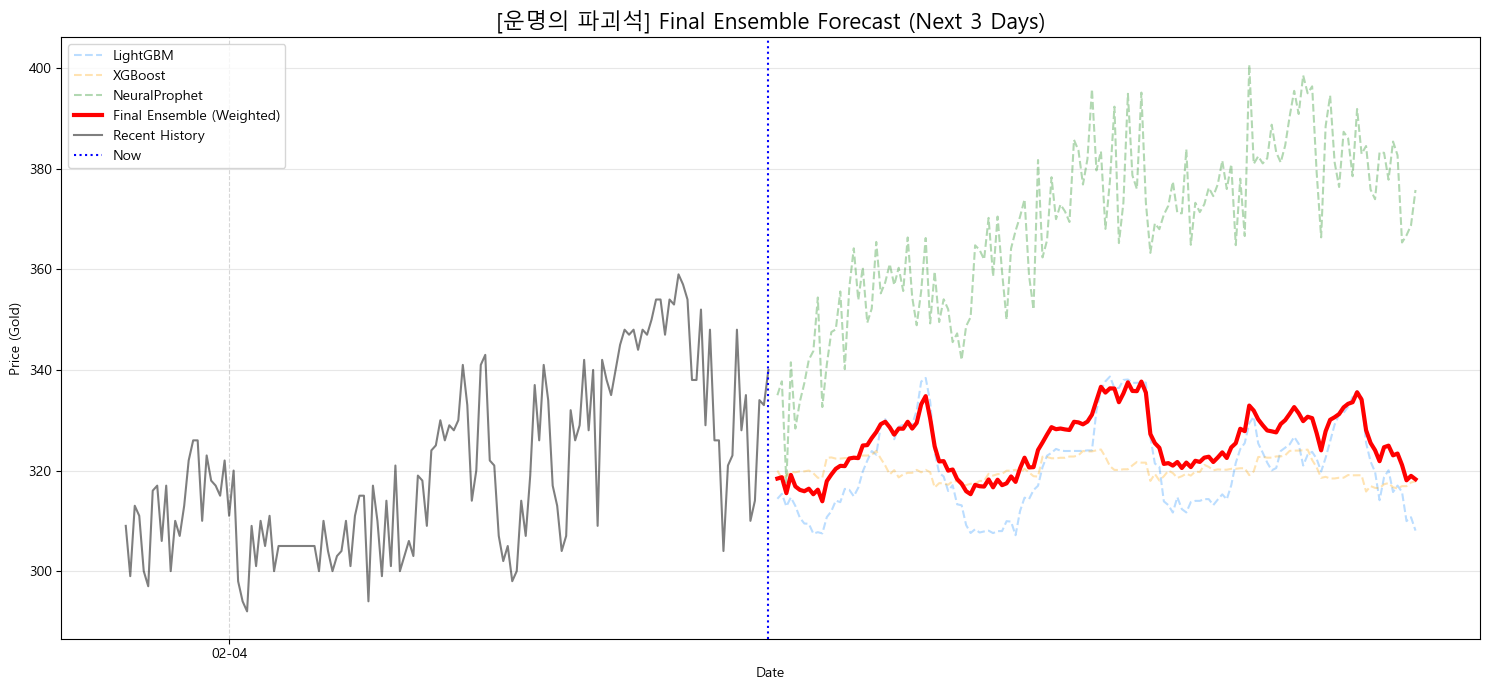

--------------------------------------------------
🏆 [최종 앙상블 예측 리포트]
--------------------------------------------------
   - 3일 뒤 예상 가격: 318 G
   - 기간 내 최저가  : 314 G
   - 기간 내 최고가  : 338 G (02-08 05:30)
--------------------------------------------------


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ---------------------------------------------------------
# 1. 데이터프레임 표준화 (이름 통일)
# ---------------------------------------------------------
print("🧩 3대장 모델 결과 합체 중...")

# (1) LightGBM 정리
# 컬럼: Date, Price -> ds, LGBM
df_lgbm_final = df_future_lgbm.rename(columns={'Date': 'ds', 'Price': 'LGBM'})
df_lgbm_final = df_lgbm_final[['ds', 'LGBM']]

# (2) XGBoost 정리
# 컬럼: 날짜, 예측가격 -> ds, XGB
df_xgb_final = forecast_3days_xgb.rename(columns={'날짜': 'ds', '예측가격': 'XGB'})
df_xgb_final = df_xgb_final[['ds', 'XGB']]

# (3) NeuralProphet 정리
# 컬럼: 날짜, 예측가격 -> ds, NP
df_np_final = forecast_3days.rename(columns={'날짜': 'ds', '예측가격': 'NP'})
df_np_final = df_np_final[['ds', 'NP']]

# ---------------------------------------------------------
# 2. 데이터 병합 (Merge)
# ---------------------------------------------------------
# 날짜(ds)를 기준으로 3개를 하나로 합칩니다.
df_ensemble = pd.merge(df_lgbm_final, df_xgb_final, on='ds', how='inner')
df_ensemble = pd.merge(df_ensemble, df_np_final, on='ds', how='inner')

print(f"✅ 병합 완료! 데이터 개수: {len(df_ensemble)}개")
# display(df_ensemble.head()) # 확인용

# ---------------------------------------------------------
# 3. 가중치 적용 (Weighted Average)
# ---------------------------------------------------------
# 전략: LightGBM(55%) + XGBoost(35%) + NeuralProphet(10%)
w_lgbm = 0.55
w_xgb = 0.35
w_np = 0.10

print(f"⚖️ 가중치 적용: Light({w_lgbm}) + XGB({w_xgb}) + NP({w_np})")

df_ensemble['Ensemble'] = (
    (df_ensemble['LGBM'] * w_lgbm) +
    (df_ensemble['XGB'] * w_xgb) +
    (df_ensemble['NP'] * w_np)
)

# ---------------------------------------------------------
# 4. 최종 시각화 (하이라이트)
# ---------------------------------------------------------
plt.figure(figsize=(15, 7))

# (1) 개별 모델 (흐리게 표시)
plt.plot(df_ensemble['ds'], df_ensemble['LGBM'], label='LightGBM', color='dodgerblue', alpha=0.3, linestyle='--')
plt.plot(df_ensemble['ds'], df_ensemble['XGB'], label='XGBoost', color='orange', alpha=0.3, linestyle='--')
plt.plot(df_ensemble['ds'], df_ensemble['NP'], label='NeuralProphet', color='green', alpha=0.3, linestyle='--')

# (2) 앙상블 (진하게 강조)
plt.plot(df_ensemble['ds'], df_ensemble['Ensemble'], label='Final Ensemble (Weighted)', color='red', linewidth=3)

# (3) 과거 데이터 연결 (시각적 연속성)
# df_ml의 마지막 2일치만 가져와서 연결감을 줍니다.
recent_history = df_ml.tail(144) # 48 * 2 = 96 (2일)
plt.plot(recent_history.index, recent_history['Close'], label='Recent History', color='black', alpha=0.5)

# 기준선
current_now = df_ml.index[-1]
plt.axvline(current_now, color='blue', linestyle=':', label='Now')

plt.title(f"[{TARGET_ITEM}] Final Ensemble Forecast (Next 3 Days)", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Price (Gold)")
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)

# X축 포맷
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.WEDNESDAY, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax.grid(True, which='major', axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# 5. 최종 리포트 출력
# ---------------------------------------------------------
last_price = df_ensemble['Ensemble'].iloc[-1]
min_price = df_ensemble['Ensemble'].min()
max_price = df_ensemble['Ensemble'].max()
max_date = df_ensemble.loc[df_ensemble['Ensemble'].idxmax(), 'ds']

print("-" * 50)
print(f"🏆 [최종 앙상블 예측 리포트]")
print("-" * 50)
print(f"   - 3일 뒤 예상 가격: {last_price:.0f} G")
print(f"   - 기간 내 최저가  : {min_price:.0f} G")
print(f"   - 기간 내 최고가  : {max_price:.0f} G ({max_date.strftime('%m-%d %H:%M')})")
print("-" * 50)

In [10]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from neuralprophet import NeuralProphet, set_random_seed, load
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ---------------------------------------------------------
# 1. 평가 함수 정의
# ---------------------------------------------------------
def get_score(y_true, y_pred, name):
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    
    # RMSE, MAE, MAPE, R2
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-7))) * 100
    r2 = r2_score(y_true, y_pred)
    
    # 방향 정확도
    true_diff = np.diff(y_true)
    pred_diff = np.diff(y_pred)
    dir_acc = (np.sum(np.sign(true_diff) == np.sign(pred_diff)) / len(true_diff)) * 100
    
    print("-" * 60)
    print(f"🏆 [{name} 성적표]")
    print(f"   - RMSE: {rmse:.2f}")
    print(f"   - MAE : {mae:.2f}")
    print(f"   - MAPE: {mape:.2f}%")
    print(f"   - r2  : {r2:.2f}")
    print(f"   - Dir Acc: {dir_acc:.1f}%")
    print("-" * 60)
    return mae

# ---------------------------------------------------------
# 2. 데이터 다시 다듬기 (df_final 재가공 - 정밀 이상치 제거)
# ---------------------------------------------------------
print("🔄 [1단계] 데이터 품질 업그레이드 중... (Sigma=3 정제)")

# (1) 마법의 정제 함수
def clean_outliers_rolling(df, column='Close', window=48, sigma=3):
    df_clean = df.copy()
    rolling_mean = df_clean[column].rolling(window=window, center=True).mean()
    rolling_std = df_clean[column].rolling(window=window, center=True).std()
    
    upper = rolling_mean + (sigma * rolling_std)
    lower = rolling_mean - (sigma * rolling_std)
    
    outliers = (df_clean[column] > upper) | (df_clean[column] < lower)
    cnt = outliers.sum()
    
    if cnt > 0:
        print(f"   🚨 {cnt}개의 노이즈 발견! 부드럽게 보정합니다.")
        df_clean.loc[outliers, column] = np.nan
        df_clean[column] = df_clean[column].interpolate()
    else:
        print("   ✅ 이미 깨끗합니다.")
        
    return df_clean

# (2) 정제 실행
df_refined = clean_outliers_rolling(df_final, column='Close', window=48, sigma=3)

# ---------------------------------------------------------
# 3. 머신러닝 데이터셋 재생성 & 모델 학습
# ---------------------------------------------------------
print("⚙️ [2단계] 머신러닝(Light, XGB) 재학습 중...")

df_ml = df_refined.copy()
df_ml['MA_5'] = df_ml['Close'].rolling(5).mean()
df_ml['MA_48'] = df_ml['Close'].rolling(48).mean()
df_ml['Std_20'] = df_ml['Close'].rolling(20).std()

delta = df_ml['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
rs = gain / loss
df_ml['RSI'] = 100 - (100 / (1 + rs))

df_ml['Close_Lag1'] = df_ml['Close'].shift(1)
df_ml['Close_Lag2'] = df_ml['Close'].shift(2)
df_ml['GPT_Lag1'] = df_ml['GPT_Score'].shift(1)
df_ml['Hour'] = df_ml.index.hour
df_ml['DayOfWeek'] = df_ml.index.dayofweek
df_ml['Target'] = df_ml['Close'].shift(-1)
df_ml = df_ml.dropna()

cutoff = pd.to_datetime("2026-02-04 06:00:00")
features = ['MA_5', 'MA_48', 'Std_20', 'RSI', 'Close_Lag1', 'Close_Lag2', 'GPT_Lag1', 'Hour', 'DayOfWeek']

X_train = df_ml[df_ml.index < cutoff][features]
y_train = df_ml[df_ml.index < cutoff]['Target']
X_valid = df_ml[df_ml.index >= cutoff][features]
y_valid = df_ml[df_ml.index >= cutoff]['Target']

print(f"   - 학습용: {len(X_train)}개, 검증용: {len(X_valid)}개")

# (1) LightGBM
lgbm = LGBMRegressor(n_estimators=1000, learning_rate=0.01, verbose=-1, random_state=42)
lgbm.fit(X_train, y_train)
p_lgbm = lgbm.predict(X_valid)

# (2) XGBoost
xgb_mod = XGBRegressor(n_estimators=1000, learning_rate=0.01, random_state=42)
xgb_mod.fit(X_train, y_train)
p_xgb = xgb_mod.predict(X_valid)

# ---------------------------------------------------------
# 4. NeuralProphet (저장된 모델 로드)
# ---------------------------------------------------------
print("📂 [3단계] 저장된 딥러닝 모델(lostark_price_model.np) 로드 중...")

try:
    # 저장된 모델 불러오기 (재학습 X)
    m = load("lostark_price_model.np")
    print("   ✅ 모델 로드 성공! (똑똑한 모델)")
    
    # 데이터 준비
    df_np = df_refined.reset_index().rename(columns={'logged_at': 'ds', 'Close': 'y'})[['ds', 'y', 'GPT_Score']]
    df_np['ds'] = pd.to_datetime(df_np['ds'])
    
    # 예측 실행
    forecast = m.predict(df_np)
    
    # 검증 구간 추출
    mask_np = forecast['ds'] >= cutoff
    df_valid_np = forecast[mask_np].copy().dropna(subset=['y', 'yhat1'])
    p_np = df_valid_np['yhat1'].values
    
except Exception as e:
    print(f"   🚨 모델 로드 실패: {e}")
    p_np = np.zeros(len(y_valid)) # 에러 방지

# ---------------------------------------------------------
# 5. 최종 앙상블 평가
# ---------------------------------------------------------
print("\n📊 [진짜_최종_앙상블 결과]")

# 길이 맞추기
min_len = min(len(y_valid), len(p_lgbm), len(p_xgb), len(p_np))

y_true_final = y_valid.values[:min_len]
p_lgbm = p_lgbm[:min_len]
p_xgb = p_xgb[:min_len]
p_np = p_np[:min_len]

# 3대장 앙상블 (Light 5.5 : XGB 3.5 : NP 1.0)
w_lgbm, w_xgb, w_np = 0.55, 0.35, 0.10
pred_ensemble = (p_lgbm * w_lgbm) + (p_xgb * w_xgb) + (p_np * w_np)

🔄 [1단계] 데이터 품질 업그레이드 중... (Sigma=3 정제)
   🚨 7개의 노이즈 발견! 부드럽게 보정합니다.
⚙️ [2단계] 머신러닝(Light, XGB) 재학습 중...
   - 학습용: 2247개, 검증용: 109개
📂 [3단계] 저장된 딥러닝 모델(lostark_price_model.np) 로드 중...


Training: |          | 0/? [00:00<?, ?it/s]

   ✅ 모델 로드 성공! (똑똑한 모델)


INFO - (NP.df_utils._infer_frequency) - Major frequency 30min corresponds to 99.958% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 30min
INFO - (NP.df_utils._infer_frequency) - Major frequency 30min corresponds to 99.961% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 30min
INFO - (NP.data.processing._handle_missing_data) - Dropped 144 rows at the end with NaNs in future regressors.


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column



📊 [진짜_최종_앙상블 결과]


In [11]:
# ---------------------------------------------------------
# 6. 최종 성적표 출력
# ---------------------------------------------------------

get_score(y_true_final, p_lgbm, "LightGBM (단독)")
get_score(y_true_final, p_xgb, "XGBoost (단독)")
get_score(y_true_final, p_np, "NeuralProphet (저장된 파일)")

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

In [ ]:
get_detailed_score(y_true_final, pred_ensemble, "✨ 3대장 앙상블 (딥러닝 포함)")